http://brandonrose.org/clustering

In [5]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import cPickle as pickle
import data_grab

In [7]:
reviews = data_grab.get_reviews()

In [16]:
restaurant = reviews.business_id
texts = reviews.text

In [13]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

In [14]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [15]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [17]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in texts:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [19]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

ValueError: Shape of passed values is (1, 29639825), indices imply (1, 29639824)

In [86]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(texts) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

CPU times: user 1min 15s, sys: 4.69 s, total: 1min 19s
Wall time: 1min 23s
(200, 1260)


In [87]:
terms = tfidf_vectorizer.get_feature_names()

In [88]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [89]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 309 ms, sys: 8.36 ms, total: 317 ms
Wall time: 331 ms


In [90]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

# joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

['doc_cluster.pkl', 'doc_cluster.pkl_01.npy', 'doc_cluster.pkl_02.npy']

In [100]:
bills = { 'title': titles, 'vote': result, 'text': texts, 'cluster': clusters, 'sponsor': sponsor, "subject_top": subject_top, "subjects": subjects, 'category':categories, 'congress':congress, 'bill_type':bill_type, 'number':number, 'requires':requires}
 
frame = pd.DataFrame(bills, index = [clusters] , columns = ['vote', 'title', 'cluster', 'sponsor', 'subject_top', 'subjects', 'category', 'requires'])

In [101]:
frame

,vote,title,cluster,sponsor,subject_top,subjects,category,requires
4,Passed,Providing for consideration of the bill (H.R. ...,4,"{u'name': u'Woodall, Rob', u'district': u'7', ...",Congress,"[Congress, House of Representatives, Legislati...",procedural,1/2
4,Passed,Providing for consideration of the bill (H.R. ...,4,"{u'name': u'Woodall, Rob', u'district': u'7', ...",Congress,"[Congress, House of Representatives, Legislati...",passage,1/2
3,Passed,To define STEM education to include computer s...,3,"{u'name': u'Smith, Lamar', u'district': u'21',...",Education,"[Computers and information technology, Educati...",passage-suspension,2/3
1,Failed,To amend the Internal Revenue Code of 1986 to ...,1,"{u'name': u'Jenkins, Lynn', u'district': u'2',...",Taxation,"[Computers and information technology, Educati...",recommit,1/2
3,Failed,To make technical corrections to the Dodd-Fran...,3,"{u'name': u'Fitzpatrick, Michael G.', u'distri...",Finance and financial sector,"[Administrative law and regulatory procedures,...",passage-suspension,2/3
1,Passed,To amend the Internal Revenue Code of 1986 to ...,1,"{u'name': u'Jenkins, Lynn', u'district': u'2',...",Taxation,"[Computers and information technology, Educati...",passage,1/2
4,Passed,Providing for further consideration of the bil...,4,"{u'name': u'Foxx, Virginia', u'district': u'5'...",Congress,"[Congress, House of Representatives, Legislati...",procedural,1/2
4,Passed,Providing for further consideration of the bil...,4,"{u'name': u'Foxx, Virginia', u'district': u'5'...",Congress,"[Congress, House of Representatives, Legislati...",procedural,1/2
4,Passed,Providing for further consideration of the bil...,4,"{u'name': u'Foxx, Virginia', u'district': u'5'...",Congress,"[Congress, House of Representatives, Legislati...",passage,1/2
3,Failed,To support State and local accountability for ...,3,"{u'name': u'Kline, John', u'district': u'2', u...",Education,"[Academic performance and assessments, Adminis...",amendment,1/2


In [92]:
frame['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)

3    81
4    41
0    32
2    28
1    18
dtype: int64

In [93]:
frame['Passed'] = pd.get_dummies(frame['vote'])['Passed']

In [94]:
grouped = frame['Passed'].groupby(frame['cluster']) #groupby cluster for aggregation purposes

grouped.mean() #average rank (1 to 100) per cluster

cluster
0    0.187500
1    0.666667
2    0.214286
3    0.617284
4    1.000000
Name: Passed, dtype: float64

In [95]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: available, funds, expense, appropriations, department, remain,

Cluster 0 titles: Making appropriations for the Department of Homeland Security for the fiscal year ending September 30, 2015, and for other purposes., Making appropriations for the Department of Homeland Security for the fiscal year ending September 30, 2015, and for other purposes., Making appropriations for military construction, the Department of Veterans Affairs, and related agencies for the fiscal year ending September 30, 2016, and for other purposes., Making appropriations for military construction, the Department of Veterans Affairs, and related agencies for the fiscal year ending September 30, 2016, and for other purposes., Making appropriations for military construction, the Department of Veterans Affairs, and related agencies for the fiscal year ending September 30, 2016, and for other purposes., Making appropriations for military construction, the Department of Veterans

In [103]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [104]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'available, funds, appropriations', 
                 1: 'internal, code, revenue', 
                 2: 'agency, rules, proposes', 
                 3: 'subsection, striking, secretary', 
                 4: 'resolution, house, reported'}

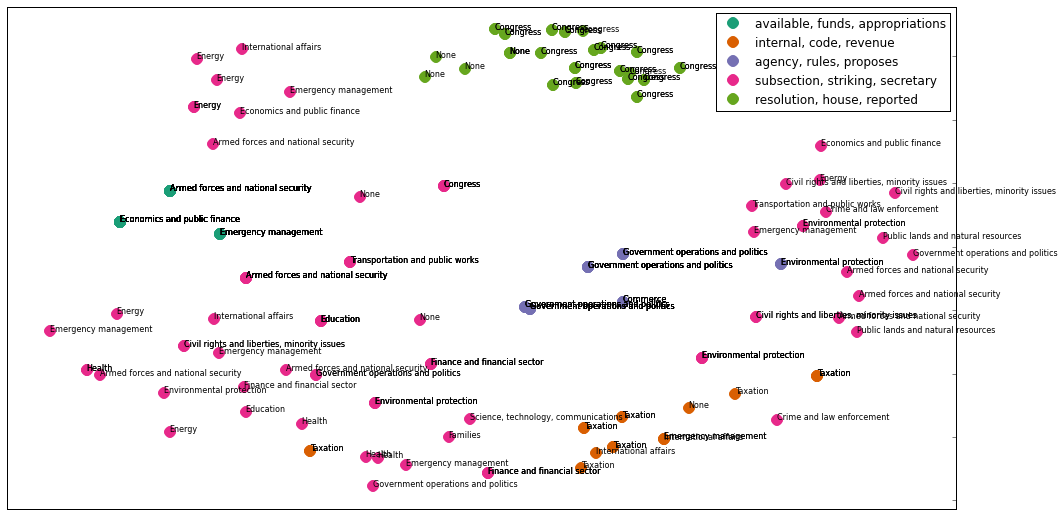

In [116]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=subject_top)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
# plt.savefig('clusters_small_noaxes.png', dpi=200)

In [118]:
'''
The below javascript snippet basicaly defines a custom location for where the zoom/pan
toggle resides. Don't worry about it too much and you actually don't need to use it,
but it helped for formatting purposes when exporting to the web later. The only thing
you might want to change is the x and y attr for the position of the toolbar.
'''
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [119]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

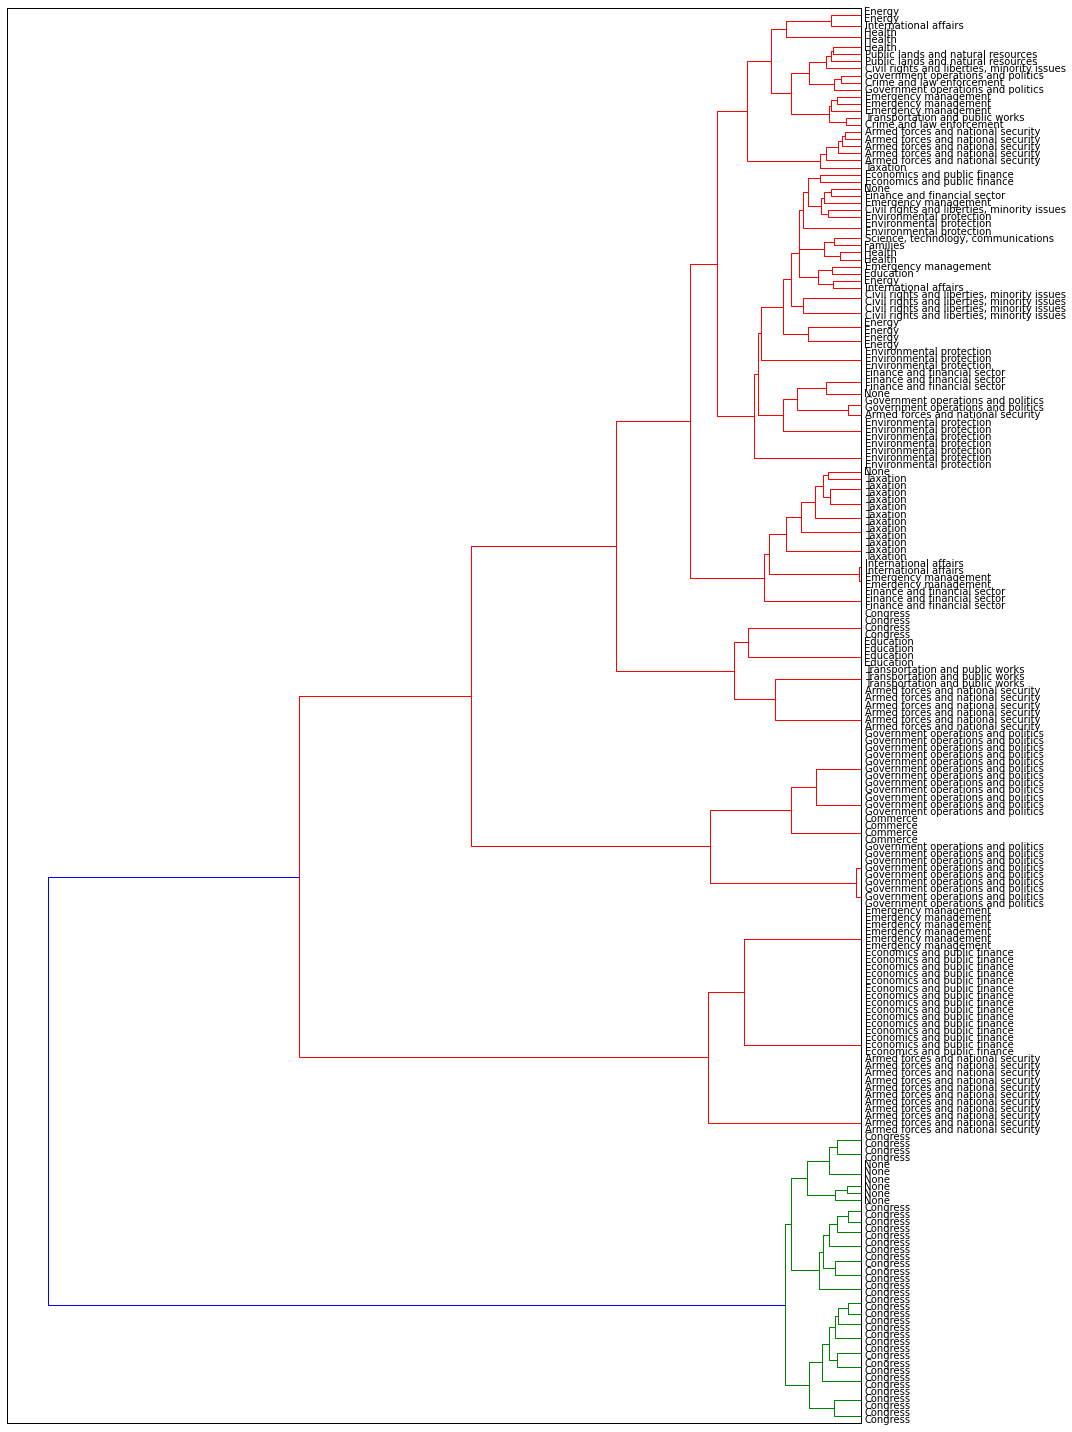

In [127]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=subject_top);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [130]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [132]:
'''
Since the above function is just based on capitalization, it is prone to remove 
words at the beginning of sentences. So, I wrote the below function using NLTK's
part of speech tagger. However, it took way too long to run across all synopses,
so I stuck with the above.
'''
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [134]:
from gensim import corpora, models, similarities 

#remove proper names
%time preprocess = [strip_proppers(doc) for doc in texts]

#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

#remove stop words
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

CPU times: user 30.2 s, sys: 2.21 s, total: 32.4 s
Wall time: 35.1 s
CPU times: user 42.3 s, sys: 3.35 s, total: 45.7 s
Wall time: 47.4 s
CPU times: user 3.97 s, sys: 181 ms, total: 4.15 s
Wall time: 4.22 s


/Users/amangum/Virtualenvs/metis/lib/python2.7/site-packages/numpy/lib/utils.py:95: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  warnings.warn(depdoc, DeprecationWarning)
/Users/amangum/Virtualenvs/metis/lib/python2.7/site-packages/scipy/lib/_util.py:67: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/Users/amangum/Virtualenvs/metis/lib/python2.7/site-packages/scipy/lib/_util.py:67: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/Users/amangum/Virtualenvs/metis/lib/python2.7/site-packages/scipy/lib/_util.py:67: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/Users/amangum/Virtualenvs/metis/lib/python2.7/site-packages/scipy/lib/_util.py:67: DeprecationWarning: Module scipy.

In [135]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [139]:
'''
The actual model runs below. I took 100 passes to ensure convergence, but you can see
that it took my machine 13 minutes to run. My chunksize is larger than the corpus so
basically all synopses are used per pass. I should optimize this, and Gensim has the capacity to run in parallel. I'll likely explore this further as I use the implementation on larger corpora.
'''
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

CPU times: user 9min 11s, sys: 19.3 s, total: 9min 31s
Wall time: 9min 51s


In [140]:
lda.show_topics()

[u'0.020*section + 0.017*inform + 0.015*subsect + 0.012*entiti + 0.012*requir + 0.011*paragraph + 0.010*includ + 0.009*term + 0.009*date + 0.009*enact',
 u'0.034*avail + 0.027*fund + 0.019*section + 0.016*expens + 0.014*made + 0.014*appropri + 0.013*includ + 0.013*amount + 0.013*use + 0.012*author',
 u'0.020*section + 0.017*year + 0.014*author + 0.013*bill + 0.012*titl + 0.012*strike + 0.012*program + 0.012*insert + 0.011*order + 0.011*subsect',
 u'0.035*educ + 0.032*agenc + 0.025*school + 0.020*program + 0.018*section + 0.017*local + 0.014*student + 0.012*children + 0.011*fund + 0.011*provid',
 u'0.049*rule + 0.044*agenc + 0.023*section + 0.017*propos + 0.014*subsect + 0.013*titl + 0.012*includ + 0.011*determin + 0.011*cost + 0.010*make']

In [141]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)
topics_matrix = np.array(topics_matrix)

topic_words = topics_matrix[:,:,1]
for i in topic_words:
    print([str(word) for word in i])
    print()

['section', 'inform', 'subsect', 'entiti', 'requir', 'paragraph', 'includ', 'term', 'date', 'enact', 'use', 'person', 'provid', 'subparagraph', 'insert', 'threat', 'report', 'measur', 'end', 'c']

['avail', 'fund', 'section', 'expens', 'made', 'appropri', 'includ', 'amount', 'use', 'author', 'year', 'remain', 'titl', 'activ', 'necessari', 'project', 'provid', 'fiscal', 'program', 'transfer']

['section', 'year', 'author', 'bill', 'titl', 'strike', 'program', 'insert', 'order', 'subsect', 'fiscal', 'provid', 'requir', 'consid', 'defens', 'paragraph', 'appropri', 'resolut', 'respons', 'consider']

['educ', 'agenc', 'school', 'program', 'section', 'local', 'student', 'children', 'fund', 'provid', 'subsect', 'includ', 'applic', 'year', 'use', 'entiti', 'grant', 'receiv', 'servic', 'subpart']

['rule', 'agenc', 'section', 'propos', 'subsect', 'titl', 'includ', 'determin', 'cost', 'make', 'public', 'requir', 'action', 'insert', 'final', 'issu', 'inform', 'small', 'strike', 'paragraph']

